In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pivot-table-csv/pivot_table.csv


In [ ]:
df_p = pd.read_csv('/kaggle/input/pivot-table-csv/pivot_table.csv', index_col=0)
df_p.head()

In [3]:
print(df_p.info())

<class 'pandas.core.frame.DataFrame'>
Index: 143458 entries, 6 to 2649429
Columns: 1350 entries, 3 to 4496
dtypes: float64(1350)
memory usage: 1.4 GB
None


In [4]:
print(df_p.describe())

                 3            8           16           17           18  \
count  1524.000000  9379.000000  2517.000000  4165.000000  9419.000000   
mean      3.621391     3.136795     3.081843     2.909964     3.767597   
std       0.979281     1.293944     0.983800     0.971401     0.938786   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
25%       3.000000     2.000000     2.000000     2.000000     3.000000   
50%       4.000000     3.000000     3.000000     3.000000     4.000000   
75%       4.000000     4.000000     4.000000     3.000000     4.000000   
max       5.000000     5.000000     5.000000     5.000000     5.000000   

                26            28            30           32           33  ...  \
count  4262.000000  32397.000000  77502.000000  1629.000000  5314.000000  ...   
mean      2.752229      3.808593      3.709814     4.088398     4.127211  ...   
std       1.059191      0.967781      0.935458     1.136093     1.175380  ...   
min      

In [5]:
print(df_p.isnull().sum())

3       141934
8       134079
16      140941
17      139293
18      134039
         ...  
4488    115461
4490    135951
4492    135947
4493    138715
4496    135623
Length: 1350, dtype: int64


In [6]:
print(df_p.shape)

(143458, 1350)


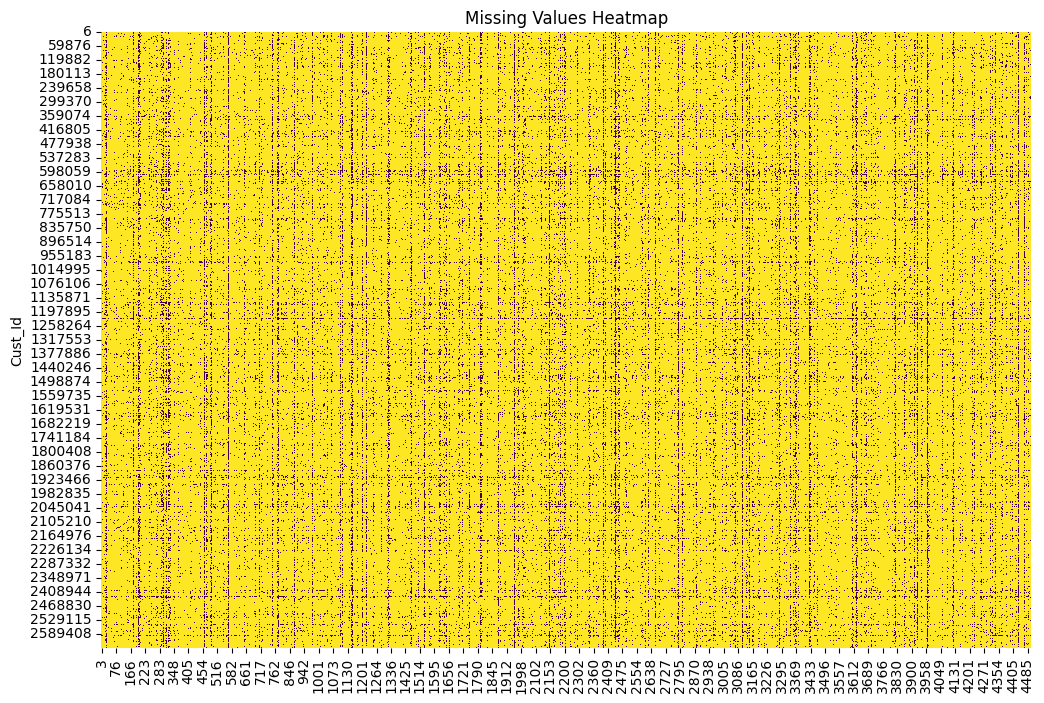

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(df_p.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [1]:
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy

In [5]:
import pandas as pd
import numpy as np
df_pivot = pd.read_csv('/kaggle/input/pivot-table-csv/pivot_table.csv', index_col=0)
print(df_pivot.columns)

Index(['3', '8', '16', '17', '18', '26', '28', '30', '32', '33',
       ...
       '4472', '4474', '4478', '4479', '4485', '4488', '4490', '4492', '4493',
       '4496'],
      dtype='object', length=1350)


In [8]:
df_melt = df_pivot.stack().reset_index().rename(columns={'level_1': 'Movie_Id', 0: 'Rating'})
print(df_melt.columns)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_melt[['Cust_Id', 'Movie_Id', 'Rating']], reader)

Index(['Cust_Id', 'Movie_Id', 'Rating'], dtype='object')


In [9]:
trainset, testset = train_test_split(data, test_size=0.2)

In [11]:
import time
sim_options = {'name': 'cosine', 'user_based': False}
knn = KNNBasic(sim_options=sim_options)
start_time = time.time()
knn.fit(trainset)
end_time = time.time()
print(f"Vreme treniranja: {end_time - start_time:.2f} sekundi")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Vreme treniranja: 112.00 sekundi


In [12]:
predictions = knn.test(testset)

accuracy.rmse(predictions)

RMSE: 0.9617


0.9617438666653579

In [21]:
inner_movie_ids = trainset.all_items()

# Pretvori unutrašnje ID-e u spoljašnje ID-e
movie_ids = [trainset.to_raw_iid(inner_id) for inner_id in inner_movie_ids]

# Ispiši spisak filmova
print("Filmovi u trenažnom setu:")
print(movie_ids)

Filmovi u trenažnom setu:
['3579', '2400', '2122', '759', '2114', '3962', '2470', '3385', '3858', '4302', '1585', '4266', '494', '668', '1482', '3505', '3605', '3563', '28', '2699', '482', '752', '3730', '2779', '4141', '3017', '2668', '3168', '1145', '311', '4432', '2913', '4012', '268', '2612', '2735', '2981', '985', '3198', '4472', '295', '2680', '257', '2743', '2252', '208', '3309', '3466', '2783', '3347', '1810', '1408', '2182', '1832', '1220', '2186', '2862', '1558', '3875', '1289', '3728', '1367', '571', '3071', '2456', '4364', '468', '3825', '1905', '3333', '720', '2430', '3030', '4496', '3090', '937', '2462', '413', '2782', '3106', '127', '2161', '3703', '1843', '175', '748', '1202', '1324', '2441', '940', '1035', '2865', '2953', '4135', '3267', '1173', '1788', '3713', '3768', '516', '1305', '2342', '1066', '1582', '2866', '4488', '1470', '3798', '4386', '2848', '4284', '331', '1571', '1882', '30', '1962', '4396', '330', '2016', '676', '733', '1256', '872', '1642', '2916', '39

In [26]:
target_movie_id = '2400'

inner_id = knn.trainset.to_inner_iid(target_movie_id)
# inner_id = 3579

neighbors = knn.get_neighbors(inner_id, k=10)

print(f"Najbliži filmovi za film ID {target_movie_id}:")
for neighbor in neighbors:
    print(knn.trainset.to_raw_iid(neighbor))
    

Najbliži filmovi za film ID 2400:
2908
750
1765
17
2388
3398
3239
4290
1518
4380
